In [1195]:
import itertools
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

PWD = Path.cwd()

In [1196]:
df = pd.read_csv(
    f'{PWD}/LLM+Answer+Evaluation_10+September+2024_10.09.tsv',
    sep='\t',
    encoding='utf-16',
)

questions = pd.read_json('../survey.jsonl', lines=True)


datasets = questions['dataset'].unique()[:-1]
models = questions['model'].unique()
dataset_model_combinations = [(d, m) for d in datasets for m in models]

POINT_SCALE = 5


def t2i(
    text: str,
    point_scale: int = 5,
) -> int:
    if point_scale == 5:
        mapping = {
            'Strongly disagree': 1,
            'Somewhat disagree': 2,
            'Neither agree nor disagree': 3,
            'Somewhat agree': 4,
            'Strongly agree': 5,
        }
    elif point_scale == 3:
        mapping = {
            'Strongly disagree': 1,
            'Somewhat disagree': 1,
            'Neither agree nor disagree': 2,
            'Somewhat agree': 3,
            'Strongly agree': 3,
        }

    return mapping.get(text, None)


def i2t(
    integer: int,
    point_scale: int = 5,
) -> str:
    if point_scale == 5:
        mapping = {
            1: 'SD',
            2: 'sD',
            3: 'N',
            4: 'sA',
            5: 'SA',
        }
    elif point_scale == 3:
        mapping = {
            1: 'SD',
            2: 'N',
            3: 'SA',
        }

    return mapping.get(integer, None)

In [1197]:
questions.head()

,uuid,is_attention_check,dataset,model,question,parsed_responses,html
0,1c9b5176-426a-4204-846b-a3f8b500f14f,False,Franklin,google/gemma-2-9b-it,Which country will have the lower energy consu...,"I do not have access to real-time information,...",<p><em>Which country will have the lower energ...
1,a58302d2-d144-4f4f-8f3b-b56220312d6b,False,Franklin,google/gemma-2-9b-it,Which country in Northern Europe had the highe...,Here's how to find the answer:\n\n* **Identify...,<p><em>Which country in Northern Europe had th...
2,dd5b27fd-4de8-42b6-b068-9e9f4c80e1ee,False,Franklin,google/gemma-2-9b-it,Which country in Eastern Asia had the highest ...,Here's how to find the answer:\n\n* **Identify...,<p><em>Which country in Eastern Asia had the h...
3,f7f44e54-e848-4e48-a6d7-e1fa552754d4,False,Franklin,google/gemma-2-9b-it,For the country in Micronesia that had the low...,I cannot answer this question. \n\nHere's why:...,<p><em>For the country in Micronesia that had ...
4,da574fdf-3fc9-4191-a373-b015b3584e8b,False,Franklin,google/gemma-2-9b-it,Which country will have the higher life expect...,Here's how to approach this question:\n\n* **L...,<p><em>Which country will have the higher life...


In [1198]:
# set column name to item in row 0
df.columns = df.iloc[0]
# drop the first row
df = df.drop(0)
# set index to 'PROLIFIC_PID'
df = df.set_index('PROLIFIC_PID')
# remove rows where Finished is not True
df = df[df['Finished'] == 'True']
df.head()

,Start Date,End Date,Response Type,IP Address,Progress,Duration (in seconds),Finished,Recorded Date,Response ID,Recipient Last Name,...,"3efe2b88-9e40-4a1c-8587-ac7b524f9233_1 - Would it be unusual to find a yellow perch in the Red Sea?Yes, it would be unusual to find a yellow perch in the Red Sea. Yellow perch (Perca flavescens) are freshwater fish native to North America, primarily found in lakes and rivers. The Red Sea is a saltwater environment, and yellow perch are not adapted to live in such conditions. Therefore, it is highly unlikely to encounter yellow perch in the Red Sea. - The response answers the question.","3efe2b88-9e40-4a1c-8587-ac7b524f9233_2 - Would it be unusual to find a yellow perch in the Red Sea?Yes, it would be unusual to find a yellow perch in the Red Sea. Yellow perch (Perca flavescens) are freshwater fish native to North America, primarily found in lakes and rivers. The Red Sea is a saltwater environment, and yellow perch are not adapted to live in such conditions. Therefore, it is highly unlikely to encounter yellow perch in the Red Sea. - The response includes a clear step-by-step plan of how an answer was found.","3efe2b88-9e40-4a1c-8587-ac7b524f9233_3 - Would it be unusual to find a yellow perch in the Red Sea?Yes, it would be unusual to find a yellow perch in the Red Sea. Yellow perch (Perca flavescens) are freshwater fish native to North America, primarily found in lakes and rivers. The Red Sea is a saltwater environment, and yellow perch are not adapted to live in such conditions. Therefore, it is highly unlikely to encounter yellow perch in the Red Sea. - I would be satisfied with this response if I had asked the question.","9b038805-caa5-4e34-ba1c-83856376c705_1 - Did Electronic Arts profit from Metroid sales?No, Electronic Arts (EA) did not profit from Metroid sales. The Metroid series is developed and published by Nintendo, not EA. Therefore, any profits from Metroid sales would go to Nintendo, not Electronic Arts. - The response answers the question.","9b038805-caa5-4e34-ba1c-83856376c705_2 - Did Electronic Arts profit from Metroid sales?No, Electronic Arts (EA) did not profit from Metroid sales. The Metroid series is developed and published by Nintendo, not EA. Therefore, any profits from Metroid sales would go to Nintendo, not Electronic Arts. - The response includes a clear step-by-step plan of how an answer was found.","9b038805-caa5-4e34-ba1c-83856376c705_3 - Did Electronic Arts profit from Metroid sales?No, Electronic Arts (EA) did not profit from Metroid sales. The Metroid series is developed and published by Nintendo, not EA. Therefore, any profits from Metroid sales would go to Nintendo, not Electronic Arts. - I would be satisfied with this response if I had asked the question.","6f401f5d-264c-4bd3-98a2-e3e0826eef74_1 - Can someone from New England profit by growing coffee?Growing coffee in New England presents significant challenges due to the region's climate, which is generally not suitable for coffee cultivation. Coffee plants typically thrive in tropical and subtropical climates with consistent temperatures between 60°F and 70°F (15°C to 24°C) and specific humidity levels. New England's colder winters and shorter growing seasons make it difficult to grow coffee plants outdoors.\nHowever, there are some possibilities for growing coffee in New England:\n\n\nGreenhouses: Some growers may experiment with coffee cultivation in greenhouses, where they can control temperature and humidity. This method could potentially allow for small-scale production.\n\n\nIndoor Growing: With the right equipment, coffee plants can be grown indoors. This method requires careful attention to light, temperature, and humidity but could yield small amounts of coffee.\n\n\nSpecialty Markets: If successful, growers could tap into niche markets for locally grown coffee, which may attract consumers interested in unique or sustainable products.\n\n\nResearch and Development: Some agricultural research inst

In [1199]:
# find the uuid in the string using regex to match a 36 character string
df.columns = df.columns.str.extract(r'([a-f0-9]{8}-[a-f0-9]{4}-[a-f0-9]{4}-[a-f0-9]{4}-[a-f0-9]{12}_[1-4])')[0]
# only return columns where there is a match
df = df[df.columns.dropna()]
# drop columns with all NaN values
df = df.dropna(axis=1, how='all')

In [1200]:
df.head()

,1c9b5176-426a-4204-846b-a3f8b500f14f_1,1c9b5176-426a-4204-846b-a3f8b500f14f_2,1c9b5176-426a-4204-846b-a3f8b500f14f_3,a58302d2-d144-4f4f-8f3b-b56220312d6b_1,a58302d2-d144-4f4f-8f3b-b56220312d6b_2,a58302d2-d144-4f4f-8f3b-b56220312d6b_3,dd5b27fd-4de8-42b6-b068-9e9f4c80e1ee_1,dd5b27fd-4de8-42b6-b068-9e9f4c80e1ee_2,dd5b27fd-4de8-42b6-b068-9e9f4c80e1ee_3,f7f44e54-e848-4e48-a6d7-e1fa552754d4_1,...,2a4d3a82-d078-433f-a8e5-0afba428ddc3_3,f94c9a05-fc8a-493e-a6a6-4f59cc09a3d1_1,f94c9a05-fc8a-493e-a6a6-4f59cc09a3d1_2,f94c9a05-fc8a-493e-a6a6-4f59cc09a3d1_3,8c862220-256d-485d-aa66-2ad1fbc84610_1,8c862220-256d-485d-aa66-2ad1fbc84610_2,8c862220-256d-485d-aa66-2ad1fbc84610_3,1327c3e0-7700-4915-8b43-fce639d9cd44_1,1327c3e0-7700-4915-8b43-fce639d9cd44_2,1327c3e0-7700-4915-8b43-fce639d9cd44_3
PROLIFIC_PID,,,,,,,,,,,,,,,,,,,,,
66deeba4a302c8d358f5080e,Strongly disagree,Strongly disagree,Strongly disagree,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Strongly agree,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5f9954c879e21c000a825bd4,NaN,NaN,NaN,Strongly disagree,Somewhat agree,Somewhat disagree,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Strongly agree,Strongly agree,Strongly agree,NaN,NaN,NaN
66a1bf056ab92a8d48010903,NaN,NaN,NaN,Strongly disagree,Somewhat disagree,Strongly disagree,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Strongly agree,Somewhat disagree,Strongly agree
66adf6f866c44ee3bcae4aad,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Somewhat agree,...,NaN,Strongly agree,Strongly disagree,Strongly agree,NaN,NaN,NaN,NaN,NaN,NaN
5d09285a2b420b001a8e43f0,NaN,NaN,NaN,NaN,NaN,NaN,Strongly disagree,Somewhat agree,Somewhat agree,NaN,...,Strongly agree,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Attention checks

In [1201]:
attention_checks = [
    'd67998d7-8f14-4f50-823b-cb63027f21d9_1',
    'd67998d7-8f14-4f50-823b-cb63027f21d9_2',
    'd67998d7-8f14-4f50-823b-cb63027f21d9_3',
    'e45763f5-53c4-4006-b2f8-edfbfd7e289e_1',
    'e45763f5-53c4-4006-b2f8-edfbfd7e289e_2',
    'e45763f5-53c4-4006-b2f8-edfbfd7e289e_3',
]
# make two dataframes with the attention check columns
attention_check_df = df[attention_checks]
# drop these columns from the dataframe
df = df.drop(attention_checks, axis=1)
# confirm each column contains 'Strongly agree'
attention_check_df = attention_check_df.map(lambda x: x == 'Strongly agree')
# get the rows where not all attention checks are True
attention_check_df = attention_check_df[~attention_check_df.all(axis=1)]

In [1202]:
attention_check_df.index

Index(['5f9954c879e21c000a825bd4', '66adf6f866c44ee3bcae4aad',
       '5d09285a2b420b001a8e43f0', '5ec57f6778555257e8a3bb13',
       '6637848ec57b867569d1130f', '5eb9da8201c8981162b0cb03',
       '59b6c28723820c0001037ff5', '66df4ec6890f1f8af5ba358a',
       '663cf34a866d41573fb42f7a', '5ec28db2622c500632dc95bc',
       '66d5af018e6a60a008f35e07', '60a4127d4c901e993eb8360d',
       '60e45a8df3027ddbbe481a65', '66927b33388807909bf67d67',
       '63d13c531a527e6e1055e182', '60867f15c6327e78242c627c',
       '667044ba0555b97e214c7a58', '5e7e1679f8a96f4be83e51e4',
       '5e19b24b2bf9512392d6dd90', '66229d058f6be22dcb26239e',
       '66cb20895fabec35a88e5291', '663945510818036ee5453ff7',
       '6023df50d5c2d7069115de3f', '6413a4a1a6e064ffb173f1ce'],
      dtype='object', name='PROLIFIC_PID')

In [1203]:
# get uuids in survey
uuids_in_survey = {i.split('_')[0] for i in df.columns}
# get questions where questions['uuid'] is in uuids_in_survey
questions = questions[questions['uuid'].isin(uuids_in_survey)]
# many-to-one mapping between ('model', 'dataset') and 'uuid'. get uuids for each ('model', 'dataset') pair
grouped_uuids = questions.groupby(['dataset', 'model'])['uuid'].apply(list).to_dict()
# each uuid contains 3 variations with suffixes _1, _2, _3. create separate dataframes for each variation
ask, plan, sat = {}, {}, {}
for (dataset, model), uuids in grouped_uuids.items():
    ask[(dataset, model)] = df[[f'{uuid}_1' for uuid in uuids]]
    plan[(dataset, model)] = df[[f'{uuid}_2' for uuid in uuids]]
    sat[(dataset, model)] = df[[f'{uuid}_3' for uuid in uuids]]

ask_mean_std = pd.DataFrame(columns=['dataset', 'model', 'mean std'])
plan_mean_std = pd.DataFrame(columns=['dataset', 'model', 'mean std'])
sat_mean_std = pd.DataFrame(columns=['dataset', 'model', 'mean std'])

for (dataset, model), df in grouped_uuids.items():
    ask_mean_std = pd.concat(
        [
            ask_mean_std,
            pd.DataFrame(
                {
                    'dataset': [dataset],
                    'model': [model],
                    'mean std': [ask[(dataset, model)].map(lambda x: t2i(x, 3)).std().mean()],
                }
            ),
        ]
    )
    plan_mean_std = pd.concat(
        [
            plan_mean_std,
            pd.DataFrame(
                {
                    'dataset': [dataset],
                    'model': [model],
                    'mean std': [plan[(dataset, model)].map(lambda x: t2i(x, 3)).std().mean()],
                }
            ),
        ]
    )
    sat_mean_std = pd.concat(
        [
            sat_mean_std,
            pd.DataFrame(
                {
                    'dataset': [dataset],
                    'model': [model],
                    'mean std': [sat[(dataset, model)].map(lambda x: t2i(x, 3)).std().mean()],
                }
            ),
        ]
    )

/tmp/ipykernel_26790/3779071352.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ask_mean_std = pd.concat(
/tmp/ipykernel_26790/3779071352.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plan_mean_std = pd.concat(
/tmp/ipykernel_26790/3779071352.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, ex

In [1204]:
from scipy.stats import ttest_rel

dataset = 'Franklin'
model = 'meta-llama/Meta-Llama-3.1-8B-Instruct'
values = ask[(dataset, model)].map(t2i)
values = values[~pd.isna(values)]
values.sem()
# do sem for each dataset and model, taking random samples of 4 responses from each column
# check if sem increases with fewer responses

rows = []
for (dataset, model), df in grouped_uuids.items():
    cols = ask[(dataset, model)].map(lambda x: t2i(x, 5))
    # get non-nan values of columns
    cols = np.transpose(cols[~pd.isna(cols)].to_numpy())
    # remove nan values
    cols = [col[~np.isnan(col)] for col in cols]
    # compute sem for all 8 responses across all columns
    sem_8 = pd.Series([pd.Series(col).sem() for col in cols])
    sem_8_mean = sem_8.mean()
    sem_8_std = sem_8.std()
    # compute sem for all possible n=4 samples of responses
    sem_4 = []
    for col in cols:
        combs = itertools.combinations(col, 4)
        sem_4.append(pd.Series([pd.Series(comb).sem() for comb in combs]).mean())

    ci_8 = 1.96 * sem_8_mean
    ci_4 = 1.96 * np.mean(sem_4)
    ci_8_width = ci_8 * 2
    ci_4_width = ci_4 * 2

    sem = rows.append(
        {
            'dataset': dataset,
            'model': model,
            'sem-8-mean': sem_8_mean,
            # 'sem-8-std': sem_8_std,
            'sem-4-mean': np.mean(sem_4),
            # 'sem-4-std': np.std(sem_4),
            'sem_increase (%)': (np.mean(sem_4) - sem_8_mean) / sem_8_mean * 100,
            # t-test
            't-test': ttest_rel(sem_8, sem_4).pvalue < 0.05,
        }
    )

# floats to 3 decimal places
sem_df = pd.DataFrame(rows).round(2)

In [1205]:
sem_df

,dataset,model,sem-8-mean,sem-4-mean,sem_increase (%),t-test
0,Franklin,google/gemma-2-9b-it,0.47,0.59,24.76,False
1,Franklin,meta-llama/Meta-Llama-3.1-8B-Instruct,0.21,0.26,24.17,False
2,Franklin,microsoft/Phi-3.5-mini-instruct,0.49,0.67,36.69,True
3,Franklin,openai/gpt-4o-mini,0.37,0.47,28.16,False
4,GSM8k,google/gemma-2-9b-it,0.19,0.21,10.79,False
5,GSM8k,meta-llama/Meta-Llama-3.1-8B-Instruct,0.30,0.36,18.99,False
6,GSM8k,microsoft/Phi-3.5-mini-instruct,0.44,0.57,28.45,False
7,GSM8k,openai/gpt-4o-mini,0.13,0.14,10.49,False
8,HotpotQA,google/gemma-2-9b-it,0.35,0.47,34.27,False
9,HotpotQA,meta-llama/Meta-Llama-3.1-8B-Instruct,0.27,0.31,15.38,False


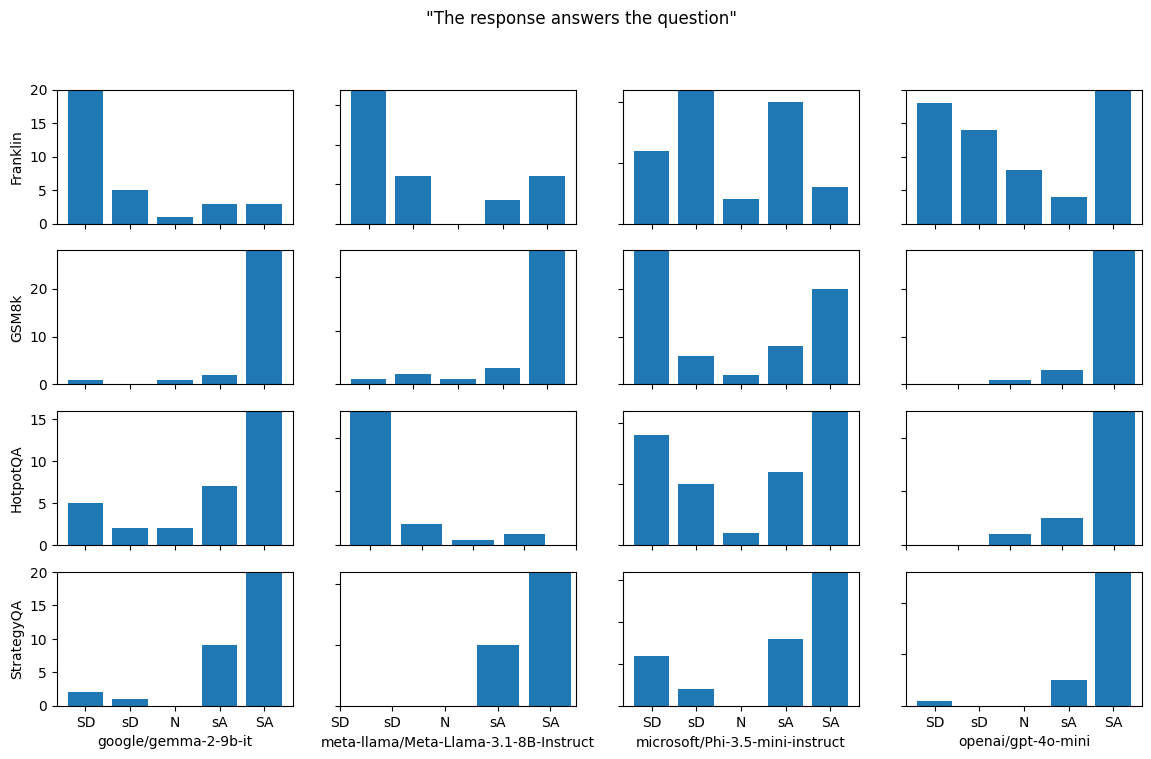

In [1206]:
point_scale = 5

# subplots in a 4x4 grid
fig, axs = plt.subplots(4, 4, figsize=(14, 8))

for d, dataset in enumerate(datasets):
    for m, model in enumerate(models):
        values = ask[(dataset, model)].map(lambda x: t2i(x, point_scale)).to_numpy()
        # remove nan values from numpy array
        values = values[~pd.isna(values)]
        # frequency of each value
        counts = pd.Series(values).value_counts()
        # plot the frequency of each value
        axs[d, m].bar(counts.index, counts.values)
        # set x axis to i2t for each value
        axs[d, m].set_xticks(range(1, point_scale + 1))
        axs[d, m].set_xticklabels([i2t(i, point_scale) for i in range(1, point_scale + 1)], ha='center')
        # set y axis to 0-max frequency
        axs[d, m].set_ylim(0, counts.max())
        # set x axis label to the model
        axs[d, m].set_xlabel(model)
        # set y axis label to the dataset
        axs[d, m].set_ylabel(dataset)

# only show bottom x axis labels
for ax in axs.flat:
    ax.label_outer()

# set the title of the entire plot
fig.suptitle('"The response answers the question"')
plt.show()

In [1207]:
dataset = 'Franklin'
dataset = 'GSM8k'
dataset = 'HotpotQA'
dataset = 'StrategyQA'
model = 'google/gemma-2-9b-it'
model = 'meta-llama/Meta-Llama-3.1-8B-Instruct'
model = 'microsoft/Phi-3.5-mini-instruct'
model = 'openai/gpt-4o-mini'
# get questions['question'] with uuids from grouped_uuids[(dataset, model)]
questions = questions[(questions['dataset'] == dataset) & (questions['model'] == model)]

In [1208]:
questions['question']

972                    Would George Fox support stoning?
973          Is Miami a city on the American West Coast?
974    Could Bernie Sanders visit the Metropolitan Mu...
975    Would it be difficult for Will Ferrell to win ...
Name: question, dtype: object

In [1209]:
datasets

array(['Franklin', 'GSM8k', 'HotpotQA', 'StrategyQA'], dtype=object)